Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil

**Data Import**

 - Install gdown package to download files from google drive.
 - Download the zip file from the path - **https://drive.google.com/uc?id=1Y-zrnB-P15z4iCbUKzFvi7_zF5eJ9gTp**
 - Extract the zip file into the folder **/content/CNN_assignment**.

In [2]:
## remove the existing zip file
shutil.rmtree('/content/CNN_assignment.zip', ignore_errors=True)

In [3]:
## Initiate the file download
!pip install gdown
import gdown
url="https://drive.google.com/uc?id=1Y-zrnB-P15z4iCbUKzFvi7_zF5eJ9gTp"
output = "CNN_assignment.zip"
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1Y-zrnB-P15z4iCbUKzFvi7_zF5eJ9gTp
To: /content/CNN_assignment.zip
824MB [00:03, 253MB/s]


'CNN_assignment.zip'

In [4]:
## unzip the downloaded folder
shutil.rmtree('/content/CNN_assignment', ignore_errors=True)
shutil.unpack_archive("CNN_assignment.zip", "CNN_assignment")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
## Check the total number of samples
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

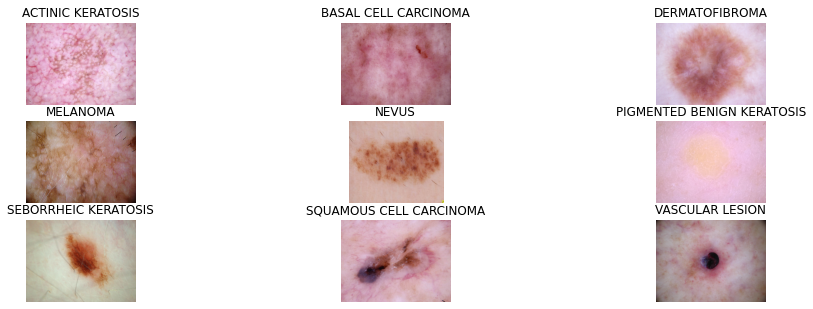

In [11]:
from os import listdir
from os.path import join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
### showing images directly from the folders without resizing
%matplotlib inline
image_indexes = [0]
selected_image_file_paths = {}
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    image_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]

number_classes = len(class_names)
plt.figure(figsize=(16,16))    
for i,classification in enumerate(class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(number_classes,3,image_number)
        plt.title(classification.upper())
        plt.axis("off")
        plt.imshow(mpimg.imread(image))



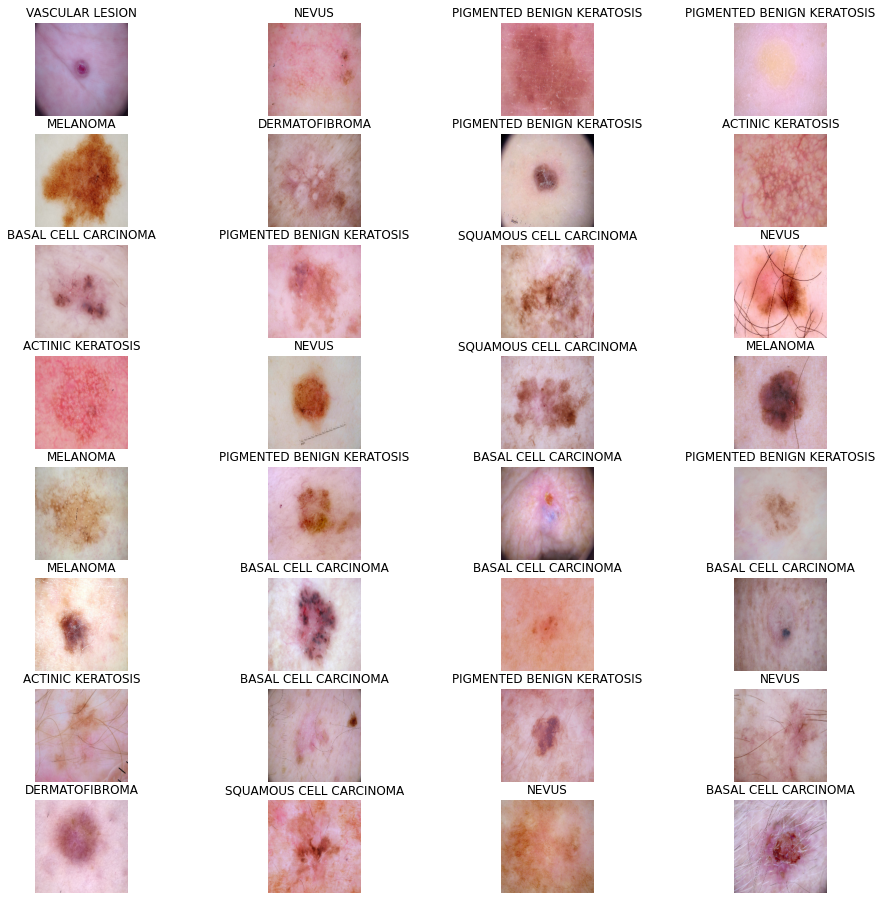

In [12]:
import matplotlib.pyplot as plt
## Show images from the first batch of the training set - it should contain 32 images
## batch_size=32 
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]].upper())
    plt.axis("off")


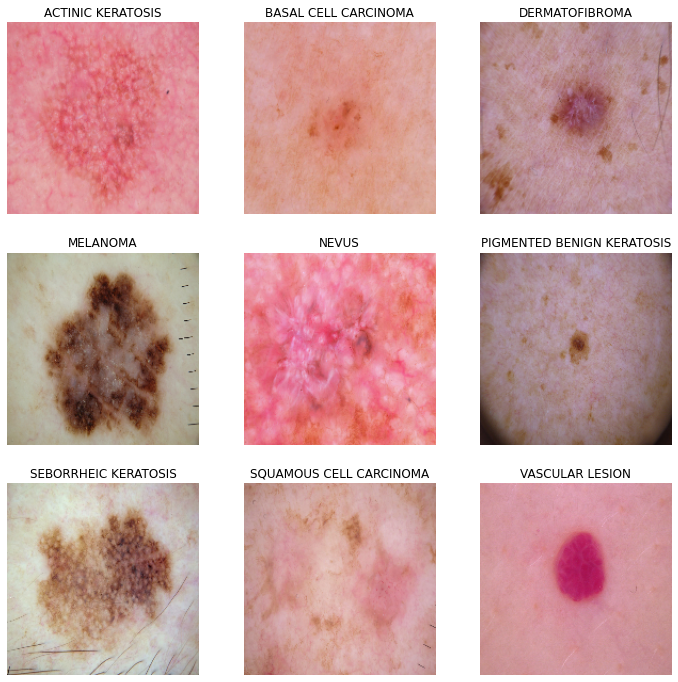

In [13]:
## Visualize one instanes of all the data set from the training data set + all batches
def get_images():
  d_dict = {}
  for images, labels in train_ds:
      for i in range(batch_size):
          if class_names[labels[i]] not in d_dict.keys():
              d_dict[class_names[labels[i]]]= images[i]
  return d_dict

def show_images():
    d_dict = get_images()
    plt.figure(figsize=(12, 12))
    for label in class_names:
        ax = plt.subplot(3, 3, class_names.index(label) + 1)
        plt.imshow(d_dict[label].numpy().astype("uint8"))
        plt.title(label.upper())
        plt.axis("off")

show_images()
        

In [14]:
## Shapes for images and labels in each batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
x_train_ds = train_ds
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:

## for details please have a look at : https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling
num_classes = len(class_names)

print(num_classes)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


9


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
### For details please have a look at : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
# View the summary of all layers
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 80ms/step - loss: 2.1575 - accuracy: 0.2263 - val_loss: 1.9327 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.8977 - accuracy: 0.2904 - val_loss: 1.6191 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6402 - accuracy: 0.4204 - val_loss: 1.5490 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5509 - accuracy: 0.4396 - val_loss: 1.4350 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3346 - accuracy: 0.5344 - val_loss: 1.3966 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2445 - accuracy: 0.5627 - val_loss: 1.4084 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1806 - accuracy: 0.5809 - val_loss: 1.3332 - val_accuracy: 0.5459
Epoch 8/20
5

### Visualizing training results

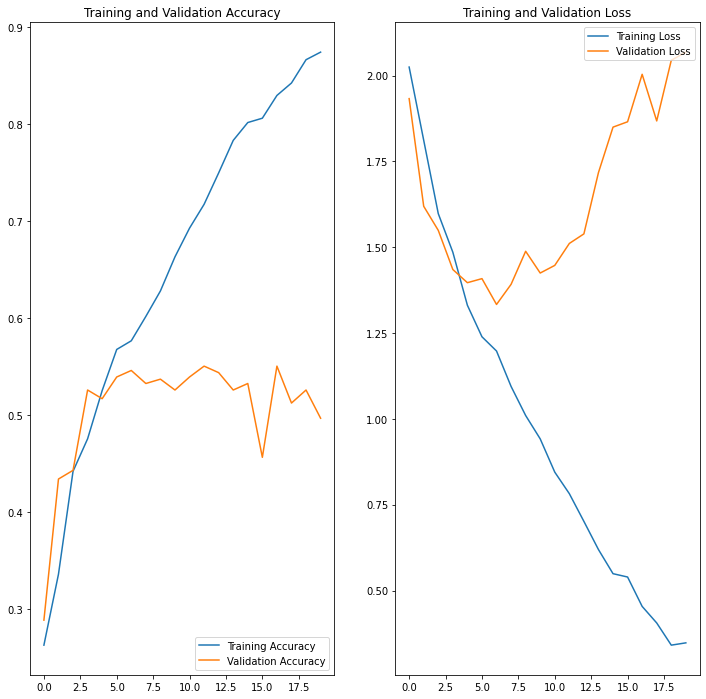

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

###Observation

At the end of 20 epochs , the model training has been completed and the training accuracy is very *high*.In general ,This is more likely due to careful control of the conditions in which the data was captured or some augmentation of the images rather than the model itself being particularly good, as it has not been **optimised**.


In [21]:
## Model summary on the performance train, validation and test set
print('Model summary')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')

Model summary
-----------------------------------------------------------------
Train accuracy on epoch 20 is 87.38839030265808%
Validation accuracy on epoch 20 is 49.66442883014679%


### Observation

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls less than 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this execise, we will use **data augmentation** and add **Dropout** to our model.

### Write your findings here

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# further details :  https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


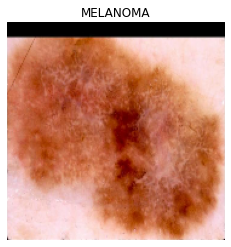

In [23]:
## Picking up a sample image to show augmentation strategy
## We are picking a sample from 'melanoma'
LABEL = 'melanoma'
d_dict = get_images()
img_m = d_dict['melanoma']

plt.imshow(img_m.numpy().astype("uint8"))
plt.title(LABEL.upper())
plt.axis("off")


# Add the image to a batch
image = tf.expand_dims(img_m,0)


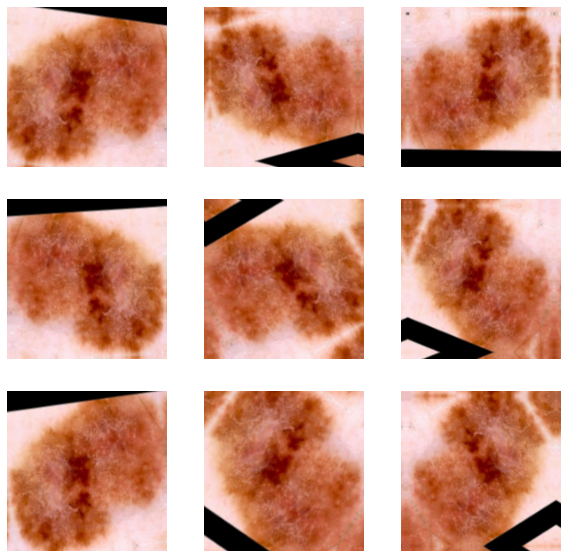

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.uint8(augmented_image[0]))
  plt.axis("off")



### Todo:
### Create the model, compile and train the model


In [25]:
## Adding dropout layers and data augmentation to avoid overfitting.
## The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
## Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

## Model building
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [26]:
## Your code goes here
## Appropriate loss function and optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [27]:
# View the summary of all layers
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 30ms/step - loss: 2.1420 - accuracy: 0.1716 - val_loss: 1.9222 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.8439 - accuracy: 0.3233 - val_loss: 1.7560 - val_accuracy: 0.3512
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6805 - accuracy: 0.3930 - val_loss: 1.4900 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4514 - accuracy: 0.4763 - val_loss: 1.4553 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4238 - accuracy: 0.4931 - val_loss: 1.4488 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3580 - accuracy: 0.5069 - val_loss: 1.4343 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.2600 - accuracy: 0.5461 - val_loss: 1.3245 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing the results

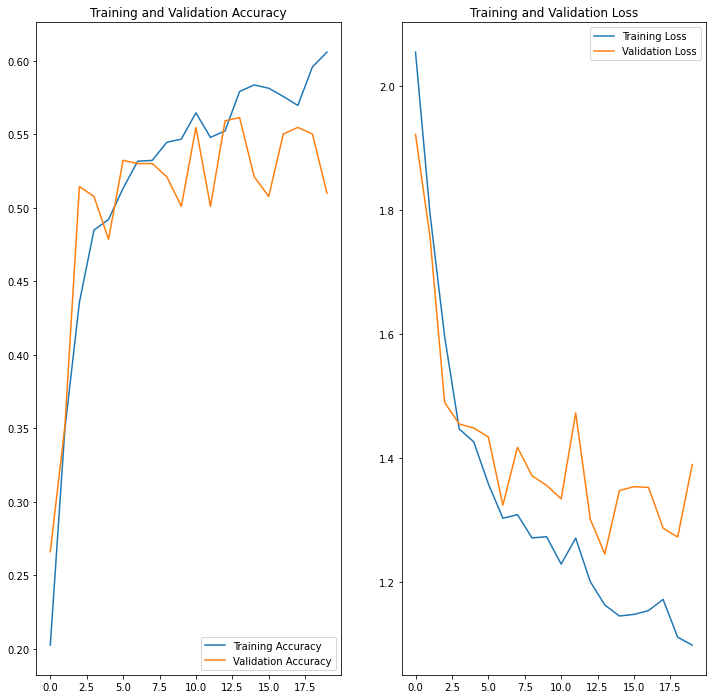

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
## Model summary on the performance train, validation and test set
print('Model summary after adding the Dense layer')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')

Model summary after adding the Dense layer
-----------------------------------------------------------------
Train accuracy on epoch 20 is 60.60267686843872%
Validation accuracy on epoch 20 is 51.00671052932739%


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Ans**: Dropout is one of the most effective and most commonly used regularization techniques for neural networks.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

After applying the dropout regularization and data augmentation technique it is clear that it imporved the  improve the behavior of the model. However the Training accuracy has been dropped significantly (near about ~60%). Let's try to check if there is any class imbalace present and increasing the no of epochs to 50.

For further details - https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#plot_the_training_and_validation_losses

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
## Your code goes here.
d_selected_image_file_paths = {}
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    d_selected_image_file_paths[classification] = len(listdir(image_directory))

lbl_df=pd.DataFrame()
df_x= pd.DataFrame(list(d_selected_image_file_paths.items()),columns = ['Class','Count'])
l_df = lbl_df.append(df_x)
print(df_x.sort_values('Count', ascending=False))

                        Class  Count
5  pigmented benign keratosis    462
3                    melanoma    438
1        basal cell carcinoma    376
4                       nevus    357
7     squamous cell carcinoma    181
8             vascular lesion    139
0           actinic keratosis    114
2              dermatofibroma     95
6        seborrheic keratosis     77


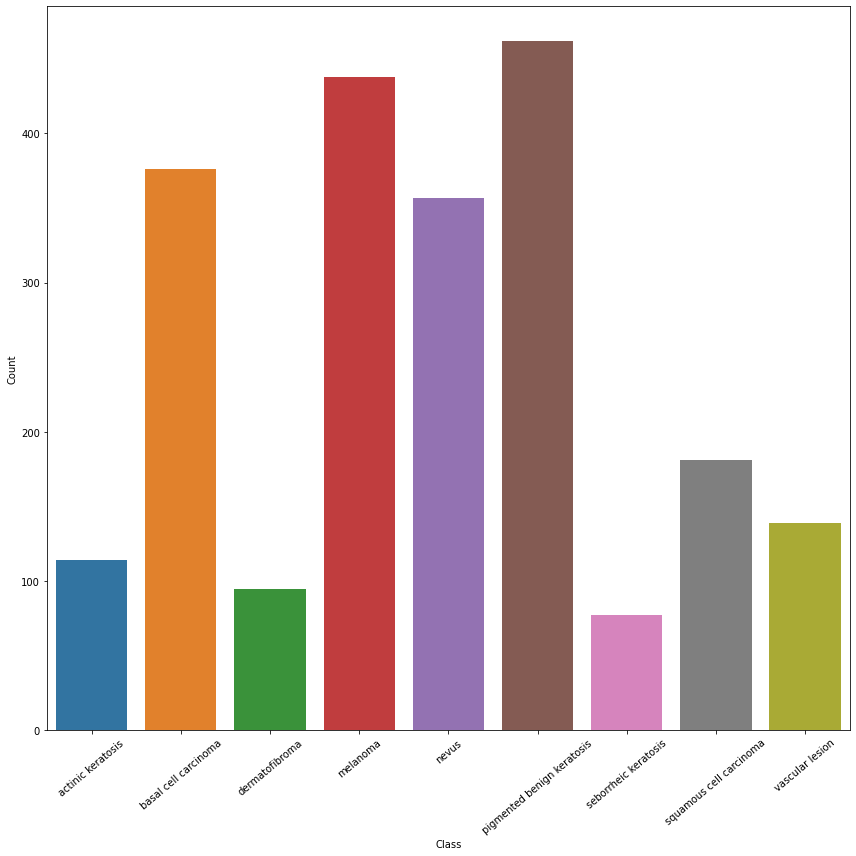

In [32]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
# class v / s fare barplot 
sns.barplot(x = 'Class', y = 'Count', data = df_x)

plt.xticks(rotation=40)
plt.tight_layout() 
# Show the plot
plt.show()


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - **Ans:** **seborrheic keratosis**, total number of samples 78
#### - Which classes dominate the data in terms proportionate number of samples?
#### - **Ans:** Top there classes in terms of proportionate number of samples are - **pigmented benign keratosis** , **melanoma**,**basal cell carcinoma**,**nevus**. These four classess contains **~73%** of the training samples.



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+'/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FACD666AD50>: 100%|██████████| 500/500 [00:15<00:00, 32.03 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FACD66B56D0>: 100%|██████████| 500/500 [00:15<00:00, 33.05 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC7C0B94D0>: 100%|██████████| 500/500 [00:15<00:00, 32.41 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FAC6BF9A050>: 100%|██████████| 500/500 [01:34<00:00,  5.32 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FACC05729D0>: 100%|██████████| 500/500 [01:20<00:00,  6.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FACD6626DD0>: 100%|██████████| 500/500 [00:15<00:00, 31.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FACD66724D0>: 100%|██████████| 500/500 [00:39<00:00, 12.71 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FACD663BA90>: 100%|██████████| 500/500 [00:15<00:00, 31.29 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FACC048FE50>: 100%|██████████| 500/500 [00:15<00:00, 31.89 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
## There should be 9x500 = 4500 images
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new=path_list
path_list

['/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_37de7950-8d8c-4a69-a12f-5d7feaf9d596.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026254.jpg_dc56b62e-d8b1-4d4f-bcbf-c9a680766a14.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_ace41655-5e06-4d58-9a83-787c982d9d15.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_b48c67e4-cdb3-4629-bd50-dc6a8f4426f8.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025668.jpg_ba3565db-4c1a-42e7-ae59-2b79702bed14.jpg',


In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [38]:

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
original_df=pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
pigmented benign keratosis    500
squamous cell carcinoma       500
basal cell carcinoma          500
nevus                         500
melanoma                      500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
## Creating models with newly added images in the Output directory
data_dir_train=pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## Adding optimizer and accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [47]:
epochs = 50
## Your code goes here, use 50 epochs.
##epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 34s 191ms/step - loss: 2.0486 - accuracy: 0.2098 - val_loss: 1.5804 - val_accuracy: 0.4135
Epoch 2/50
169/169 [==============================] - 33s 191ms/step - loss: 1.5108 - accuracy: 0.4218 - val_loss: 1.4187 - val_accuracy: 0.4863
Epoch 3/50
169/169 [==============================] - 33s 189ms/step - loss: 1.4020 - accuracy: 0.4698 - val_loss: 1.3844 - val_accuracy: 0.4625
Epoch 4/50
169/169 [==============================] - 33s 190ms/step - loss: 1.3295 - accuracy: 0.4914 - val_loss: 1.2863 - val_accuracy: 0.5219
Epoch 5/50
169/169 [==============================] - 33s 190ms/step - loss: 1.3178 - accuracy: 0.4905 - val_loss: 1.3014 - val_accuracy: 0.5071
Epoch 6/50
169/169 [==============================] - 33s 189ms/step - loss: 1.2122 - accuracy: 0.5327 - val_loss: 1.2167 - val_accuracy: 0.5345
Epoch 7/50
169/169 [==============================] - 33s 191ms/step - loss: 1.1849 - accuracy: 0.5523 - val_loss: 1.1636 - val_ac

#### **Todo:**  Visualize the model results

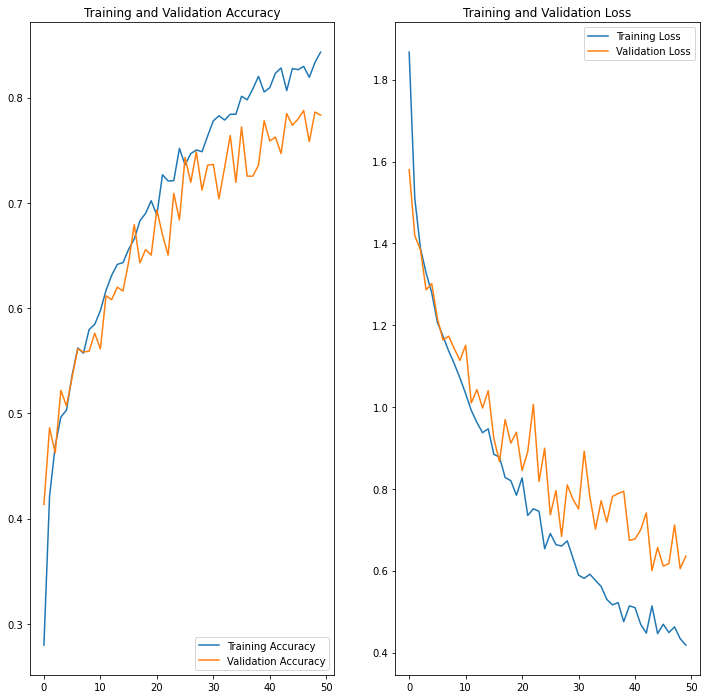

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [49]:
## Model summary on the performance train, validation and test set
print('Model summary after class rebalance')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')

Model summary after class rebalance
-----------------------------------------------------------------
Train accuracy on epoch 50 is 84.3100905418396%
Validation accuracy on epoch 50 is 78.3221960067749%


**Conclusion**

The model after class re-balance is not overfitted anymore and the model shows higher accuracy in both training and validation data.

The class re-balance is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

the most common ways to prevent overfitting in neural networks:

- Get more training data.
- Reduce the capacity of the network.
- Add weight regularization.
- Add dropout
- Add data augmentation






In [50]:
## Let's have a look at the test data set
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_test,
        image_size=(img_height,img_width),
        seed=123,
        batch_size=batch_size
    )

Found 118 files belonging to 9 classes.


In [51]:
## Evaluate model on test dataset
model.evaluate(test_ds)

4/4 [==============================] - 3s 34ms/step - loss: 6.2270 - accuracy: 0.3814


[6.226967811584473, 0.3813559412956238]

In [52]:
## Performance on un-seen data
melonomal_path= pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000036.jpg')
img = keras.preprocessing.image.load_img(
    melonomal_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to melanoma with a 98.92 percent confidence.
